# Task 1
Retrieved daily historical data of top 5 current Nifty50 stocks. Used yfinance for this. Saved it as a CSV file.

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

stocks = ["RELIANCE.NS", "HDFCBANK.NS", "TCS.NS", "BHARTIARTL.NS", "ICICIBANK.NS"]

N = 50

data = yf.download(stocks, period='300d', interval ='1d')

close = data['Close']

/tmp/ipykernel_1125802/3968362065.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, period='300d', interval ='1d')
[*********************100%***********************]  5 of 5 completed


# Task 2
Chose a lookback window of N days and computed 
1) Upper band: Highest high in the last N days.
2) Lower band: Lowest low in the last N days.

In [22]:
upperBand = pd.DataFrame(index = close.index, columns = stocks)
lowerBand = pd.DataFrame(index = close.index, columns = stocks)


# Task 3
Defining entry rules. Entering a long when today's close crosses above the upper band.

In [ ]:
for stock in stocks:
    high = data['High'][stock]
    low = data['Low'][stock]

    for i in range(N, len(close)):
        upperBand.at[close.index[i], stock] = high[i-N:i].max()
        lowerBand.at[close.index[i], stock] = low[i-N:i].min()

upperBand = upperBand.apply(pd.to_numeric)
lowerBand = lowerBand.apply(pd.to_numeric)


# Task 4
Define entry rules and exit buffers and simulate trading strategy. 


# Implementing RSI and Supertrend 
This task was added later as a modification to the strategy. The old strategy lacked several things like
1) Position sizing. It invested the entire portfolio in one stock which was not a viable option in real life scenarios
2) Allowing to hold multiple positions. The old strategy held only one stock. The modification allows it to hold more. 
3) Adding Technical Indicators like RSI and Supertrend after reading about them in Part 2 of the assignment now helps the model make better trading decisions. 

In [ ]:
def get_rsi(close, lookback=14):
    ret = close.diff()
    up = ret.clip(lower=0)
    down = -ret.clip(upper=0)
    up_ewm = up.ewm(com=lookback-1, adjust=False).mean()
    down_ewm = down.ewm(com=lookback-1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi = pd.DataFrame({stock: get_rsi(close[stock]) for stock in stocks})

def get_atr(high, low, close, lookback=10): # Implementing Supertrend will require ATR use.
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(span=lookback, adjust=False).mean()
    return atr

def get_supertrend(high, low, close, lookback=10, multiplier=3):
    atr = get_atr(high, low, close, lookback)
    hl2 = (high + low) / 2
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    
    supertrend = pd.Series(index=close.index, dtype=float)
    direction = pd.Series(index=close.index, dtype=float)
    
    # Initialize first values
    supertrend.iloc[lookback] = lowerband.iloc[lookback]
    direction.iloc[lookback] = 1
    
    for i in range(lookback + 1, len(close)):
        if close.iloc[i] <= supertrend.iloc[i-1]:
            supertrend.iloc[i] = upperband.iloc[i]
            direction.iloc[i] = -1  # Downtrend
        else:
            supertrend.iloc[i] = lowerband.iloc[i]
            direction.iloc[i] = 1   # Uptrend
    
    return supertrend, direction


supertrend = {}
direction = {}
for stock in stocks:
    st, dirn = get_supertrend(data['High'][stock], data['Low'][stock], close[stock])
    supertrend[stock] = st
    direction[stock] = dirn



In [ ]:
risk_per_trade = 0.02  # 2% of capital per trade, this defines our risk tolerance
capital = 1000000
positions = {stock: 0 for stock in stocks}
entry_prices = {stock: None for stock in stocks}
cash = capital
trades = []
portfolio_value = [initialCapital]

for i in range(N, len(close)):
    date = close.index[i]
    for stock in stocks:
        price = close.at[date, stock]
        atr = get_atr(data['High'][stock], data['Low'][stock], close[stock]).iloc[i]
        position_size = (risk_per_trade * cash) / (atr if atr > 0 else 1)


Trades executed: [{'Date': Timestamp('2024-06-18 00:00:00'), 'Stock': 'HDFCBANK.NS', 'Type': 'Entry', 'Price': np.float64(1607.800048828125), 'Shares': 736}, {'Date': Timestamp('2024-06-27 00:00:00'), 'Stock': 'RELIANCE.NS', 'Type': 'Entry', 'Price': np.float64(1530.550048828125), 'Shares': -109}, {'Date': Timestamp('2024-07-01 00:00:00'), 'Stock': 'TCS.NS', 'Type': 'Entry', 'Price': np.float64(3862.86328125), 'Shares': -4}, {'Date': Timestamp('2024-07-05 00:00:00'), 'Stock': 'HDFCBANK.NS', 'Type': 'Exit', 'Price': np.float64(1648.0999755859375), 'Shares': 736}, {'Date': Timestamp('2024-09-18 00:00:00'), 'Stock': 'HDFCBANK.NS', 'Type': 'Entry', 'Price': np.float64(1694.800048828125), 'Shares': 1280}, {'Date': Timestamp('2024-10-01 00:00:00'), 'Stock': 'HDFCBANK.NS', 'Type': 'Exit', 'Price': np.float64(1726.199951171875), 'Shares': 1280}, {'Date': Timestamp('2024-11-27 00:00:00'), 'Stock': 'HDFCBANK.NS', 'Type': 'Entry', 'Price': np.float64(1812.300048828125), 'Shares': 664}, {'Date': T

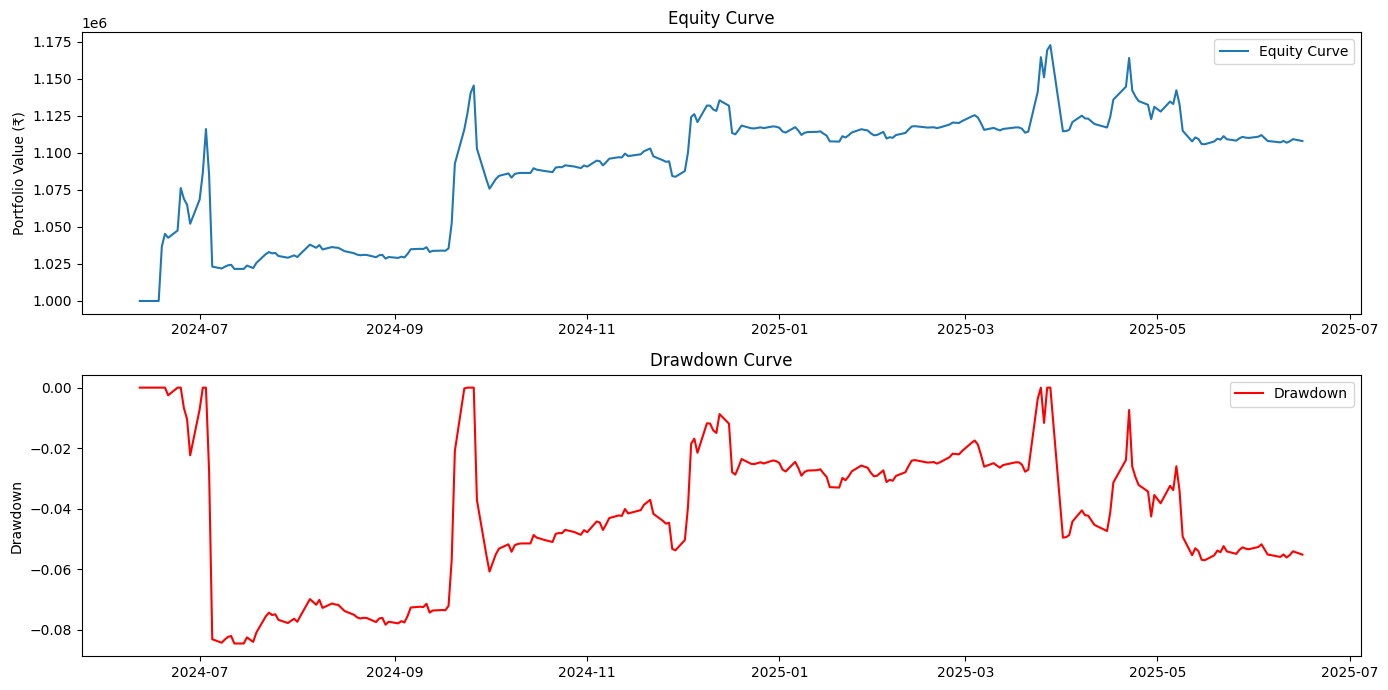

In [ ]:
entryBuffer = 0.01
exitBuffer = 0.01

initialCapital = 1000000
portfolioValue = [initialCapital]
positions = {stock: 0 for stock in stocks}
entryPrices = {stock: 0 for stock in stocks}

trades = []

for i in range(N, len(close)):
    date = close.index[i]
    for stock in stocks:
        price = close.at[date, stock]
        ub = upperBand.at[date, stock]
        lb = lowerBand.at[date, stock]
        rsi_val = rsi[stock].iloc[i]
        st_dir = direction[stock].iloc[i]

        # Entry: if not in position
        if positions[stock] == 0:
            if price > ub and rsi_val > 40 and st_dir == 1:
                # Calculate position size
                atr = get_atr(data['High'][stock], data['Low'][stock], close[stock]).iloc[i]
                size = int((risk_per_trade * cash) / (atr if atr > 0 else 1))
                positions[stock] = size
                entry_prices[stock] = price
                cash -= size * price
                trades.append({'Date': date, 'Stock': stock, 'Type': 'Entry', 'Price': price, 'Shares': size})

        # Exit: if in position
        elif positions[stock] > 0:
            if price < lb or rsi_val < 60 or st_dir == -1:
                cash += positions[stock] * price
                trades.append({'Date': date, 'Stock': stock, 'Type': 'Exit', 'Price': price, 'Shares': positions[stock]})
                positions[stock] = 0
                entry_prices[stock] = None

    # Portfolio value update
    total_value = cash + sum(positions[stock] * close.at[date, stock] for stock in stocks)
    portfolioValue.append(total_value)


# Preparing equity curve and drawdown
equityCurve = pd.Series(portfolioValue, index=close.index[N-1:len(close)+1])

# Calculate drawdown
rolling_max = equityCurve.cummax()
drawdown = (equityCurve - rolling_max) / rolling_max

# Display results
print("Trades executed:", trades)
print("Final portfolio value:", equityCurve.iloc[-1])

# Optional: Plot equity curve and drawdown
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(equityCurve, label='Equity Curve')
plt.title('Equity Curve')
plt.ylabel('Portfolio Value (₹)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown Curve')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

# Explaining the logic of this model
## 1) Our universe consists of the top 5 Nifty50 stocks. RELIANCE, HDFCBANK, TCS, BHARTIARTL, ICICIBANK.
Our data period is 300 days of OHLC data. Lookback window is 50 days for our indicator calculations\
We start with an initial capital of 10,00,000 INR. 

## 2) Techinial Indicators 
### A) Donchian Channels(Primary Trend Filter)
Upper Band: Highest high over the last 50 days.\ 
Lower Band: Lowest low over the last 50 days.\
The purpose of these bands is to identify breakouts form trading ranges. Through this we can identify potential trend reversals.\ 

### B) RSI (Momentum Oscillator)
The calculation uses a 14-period EMA (Exponential Moving Average) of gains vs losses.\ 
It ranges from 0-100 where >= 70 is marked as overbought and <=30 as oversold.\
RSI acts as a filter. It tells us about trades where momentum is favourable and where it is not. This allows us to focus computation power on limited trades.\

### C) Supertrend (Trend Direction)
ATR Based: Uses Average True Range for volatility adjustment.\
A +1 direction is considered uptrend and a -1 direction is considered downtrend. The purpose of this is to confirm trend direction before entering trades.\

### D) ATR (Position Sizing)
True range is the maximum of three prices tr1, tr2 and tr3. The purpose is to measure volatility for risk-adjusted position sizing.\

## 3) Risk Management Framework
Our basic risk control mechanism limits each trade to 2% of available capital. The volatility adjustment relates position size inversely to ATR.\
In a nutshell:\
High Volatility : Smaller Positions\
Low Volatility : Larger Positions\

We can hold multiple positions, track available cash vs invested capital and adjust position sizes based on remaining capital.\

## 4) Entry and Exit Logic
### A) Entry Conditions (All must be satisfied)
No existing position in the stock\
Breakout Signal: Current price > Upper Donchian Band\
Momentum Filter: RSI > 40 (not in oversold territory)\
Trend Confirmation: SuperTrend direction = +1 (uptrend)\

### B) Exit Conditions (Any can trigger)
Trend Breakdown: Price falls below Lower Donchian and\
Momentum Shift: RSI drops below 60 (losing momentu)\
Trend Reversal: SuperTrend direction changes to -1(downtrend)\

## 5) Trading Logic Flow 
For each trading day, after the 50 day warmup, the mofel follows the following loop.\
Calculate Indicators: Update all technical indicators\
Scan All Stocks: Check entry/exit conditions for each stock\
Execute Trades: Process entries before exits to manage cash flow\
Update Portfolio: Recalculate total portfolio value\
Risk Check: Ensure sufficient capital for new positions\

## 6) Equity Curve Calculation
Daily Portfolio Value: Cash + Market value of all holdings\
Drawdown Analysis: Maximum decline from peak value\
Trade Log: Complete record of all entry/exit transactions.\

### Key Metrics Captured:
Entry/exit dates and prices\
Number of shares per transaction\
Running portfolio value\
Maximum drawdown periods\
Win/loss ratio (implicit in equity curve)\
